In [32]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
from tqdm.auto import tqdm

from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryPrecision,
    BinaryRecall,
    BinaryConfusionMatrix,
    BinaryAUROC
)
import matplotlib.pyplot as plt


In [7]:
def load_file(path: str):
    return np.load(path).astype(np.float32)

In [8]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),                         # (H,W) -> (1,H,W)
    transforms.RandomAffine(degrees=5, translate=(0.0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1.0)),
    transforms.Normalize(mean=(0.49,), std=(0.248,)),
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=(0.49,), std=(0.248,)),
])


In [9]:
train_dataset = torchvision.datasets.DatasetFolder(
    root="processed/train",
    loader=load_file,
    extensions=("npy",),
    transform=train_transforms
)

val_dataset = torchvision.datasets.DatasetFolder(
    root="processed/val",
    loader=load_file,
    extensions=("npy",),
    transform=val_transforms
)

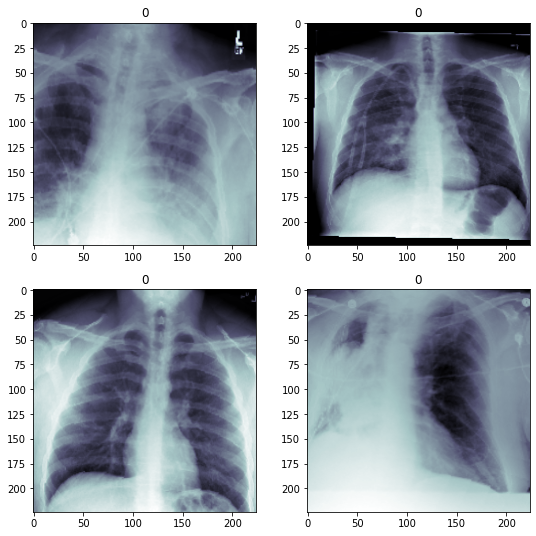

In [10]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 24000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(label)
        

In [11]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0,      
    pin_memory=False,   
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,      
    pin_memory=False,
)


In [12]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, lr=1e-4, pos_weight=3.0, pretrained=True):
        super().__init__()
        self.save_hyperparameters()

        # ---- Backbone ----
        weights = torchvision.models.ResNet18_Weights.DEFAULT if pretrained else None
        self.model = torchvision.models.resnet18(weights=weights)

        # Convert first conv from 3ch to 1ch (keep pretrained benefit)
        old_conv = self.model.conv1
        new_conv = nn.Conv2d(
            1, old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False
        )
        if pretrained:
            new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)
        self.model.conv1 = new_conv

        self.model.fc = nn.Linear(self.model.fc.in_features, 1)

        self.register_buffer("pos_weight", torch.tensor([pos_weight], dtype=torch.float32))
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)

        self.train_acc = BinaryAccuracy()
        self.val_acc = BinaryAccuracy()
        self.train_auroc = BinaryAUROC()
        self.val_auroc = BinaryAUROC()

    def forward(self, x):
        return self.model(x).squeeze(1) 

    def _shared_step(self, batch, stage: str):
        x, y = batch
        y = y.float()

        logits = self(x)
        loss = self.loss_fn(logits, y)
        probs = torch.sigmoid(logits)

        if stage == "train":
            self.train_acc.update(probs, y.int())
            self.train_auroc.update(probs, y.int())
            self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        else:
            self.val_acc.update(probs, y.int())
            self.val_auroc.update(probs, y.int())
            self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")

    def on_train_epoch_end(self):
        self.log("train/acc", self.train_acc.compute(), prog_bar=True)
        self.log("train/auroc", self.train_auroc.compute(), prog_bar=True)
        self.train_acc.reset()
        self.train_auroc.reset()

    def on_validation_epoch_end(self):
        self.log("val/acc", self.val_acc.compute(), prog_bar=True)
        self.log("val/auroc", self.val_auroc.compute(), prog_bar=True)
        self.val_acc.reset()
        self.val_auroc.reset()

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=2)
        return {"optimizer": opt, "lr_scheduler": {"scheduler": sch, "monitor": "val/loss"}}


In [13]:
checkpoint_callback = ModelCheckpoint(
    monitor="val/auroc",   
    mode="max",
    save_top_k=5,
    filename="epoch{epoch:02d}-valauroc{val/auroc:.4f}"
)

In [14]:
lr_monitor = LearningRateMonitor(logging_interval="epoch")

logger = TensorBoardLogger(save_dir="./logs", name="pneumonia")

In [15]:
trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    max_epochs=35,
    logger=logger,
    callbacks=[checkpoint_callback, lr_monitor],
    log_every_n_steps=10,
    precision="16-mixed" if torch.cuda.is_available() else 32,  # faster on GPU
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [16]:
model = PneumoniaModel()

In [17]:
batch = next(iter(val_loader))
x, y = batch
print(x.shape, y.shape, x.dtype)

torch.Size([64, 1, 224, 224]) torch.Size([64]) torch.float32


In [18]:
print("len:", len(val_dataset))
x, y = val_dataset[0]
print(type(x), getattr(x, "shape", None), y)


len: 2684
<class 'torch.Tensor'> torch.Size([1, 224, 224]) 0


In [19]:
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | ResNet            | 11.2 M | train
1 | loss_fn     | BCEWithLogitsLoss | 0      | train
2 | train_acc   | BinaryAccuracy    | 0      | train
3 | val_acc     | BinaryAccuracy    | 0      | train
4 | train_auroc | BinaryAUROC       | 0      | train
5 | val_auroc   | BinaryAUROC       | 0      | train
----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683   

Sanity Checking: |                                                                               | 0/? [00:00<…

D:\Anaconda\envs\pytorchenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\Anaconda\envs\pytorchenv\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
D:\Anaconda\envs\pytorchenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=35` reached.


In [20]:
print("Best model:", checkpoint_callback.best_model_path)

Best model: ./logs\pneumonia\version_4\checkpoints\epochepoch=04-valaurocval/auroc=0.9130.ckpt


In [21]:
best_ckpt = checkpoint_callback.best_model_path  # uses your val/auroc=0.9130 checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load on CPU first (safer), then move to device
model = PneumoniaModel.load_from_checkpoint(best_ckpt, map_location="cpu")
model.eval()
model.to(device)

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [25]:
val_eval_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=128,      
    shuffle=False,
    num_workers=0,       
    pin_memory=torch.cuda.is_available(),
)

preds_list = []
labels_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.inference_mode():  # faster than no_grad for inference
    for x, y in tqdm(val_eval_loader, desc="Validating"):
        x = x.to(device, non_blocking=True).float()
        logits = model(x)              # shape [B]
        probs = torch.sigmoid(logits)  # shape [B]

        preds_list.append(probs.detach().cpu())
        labels_list.append(y.detach().cpu())

preds = torch.cat(preds_list, dim=0)          # shape [N]
labels = torch.cat(labels_list, dim=0).int()  # shape [N]

Validating:   0%|          | 0/21 [00:00<?, ?it/s]

In [27]:
def compute_metrics(preds, labels, threshold: float):
    acc = BinaryAccuracy(threshold=threshold)(preds, labels).item()
    prec = BinaryPrecision(threshold=threshold)(preds, labels).item()
    rec = BinaryRecall(threshold=threshold)(preds, labels).item()
    cm = BinaryConfusionMatrix(threshold=threshold)(preds, labels)
    return acc, prec, rec, cm

for thr in (0.5, 0.25):
    acc, prec, rec, cm = compute_metrics(preds, labels, thr)
    print(f"\nThreshold = {thr}")
    print(f"  Acc: {acc:.4f}  Prec: {prec:.4f}  Recall: {rec:.4f}")
    print(f"  Confusion matrix:\n{cm}")


Threshold = 0.5
  Acc: 0.8249  Prec: 0.5789  Recall: 0.8182
  Confusion matrix:
tensor([[1719,  360],
        [ 110,  495]])

Threshold = 0.25
  Acc: 0.7060  Prec: 0.4311  Recall: 0.9521
  Confusion matrix:
tensor([[1319,  760],
        [  29,  576]])


In [29]:
auroc = BinaryAUROC()(preds, labels)
print("Val AUROC:", auroc.item())

Val AUROC: 0.9129961729049683


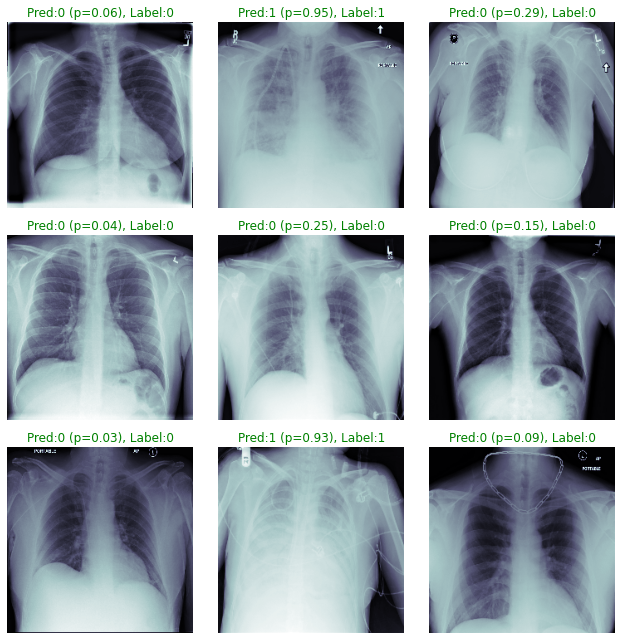

In [40]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        img = val_dataset[rnd_idx][0][0]
        prob = preds[rnd_idx].item()
        label = labels[rnd_idx].item()
        pred = int(prob > 0.5)

        axis[i][j].imshow(img, cmap="bone")
        axis[i][j].set_title(
            f"Pred:{pred} (p={prob:.2f}), Label:{label}",
            color="green" if pred == label else "red"
        )
        axis[i][j].axis("off")

plt.tight_layout()
plt.show()